# BTK Datathon 2022 Competition Study

Our goal in this competition is to predict the selling price of each product. You have to guess the value of the Product Price variable for each id in the test set.

https://www.kaggle.com/competitions/datathon2022

## Modules

In [72]:
import warnings, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

## Data Collection

In [73]:
# df_currency source: https://evds2.tcmb.gov.tr/index.php?/evds/serieMarket

df_train = pd.read_csv(filepath_or_buffer    = '/kaggle/input/datathon2022/train.csv',
                       index_col             = ['tarih'],
                       parse_dates           = ['tarih'],
                       dtype                 = {'ürün': 'category',
                                               'ürün kategorisi': 'category',
                                               'ürün üretim yeri': 'category',
                                               'market': 'category',
                                               'şehir': 'category'})

df_test = pd.read_csv(filepath_or_buffer     = '/kaggle/input/datathon2022/testFeatures.csv',
                      index_col              = ['tarih'],
                      parse_dates            = ['tarih'],
                      dtype                  = {'ürün': 'category',
                                               'ürün kategorisi': 'category',
                                               'ürün üretim yeri': 'category',
                                               'market': 'category',
                                               'şehir': 'category'})

df_currency = pd.read_csv(filepath_or_buffer = '/kaggle/input/exchange-rates/currency.csv', 
                          index_col          = 'Tarih',
                          parse_dates        = ['Tarih'])

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227520 entries, 2016-01-01 to 2020-12-01
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ürün               227520 non-null  category
 1   ürün besin değeri  227520 non-null  int64   
 2   ürün kategorisi    227520 non-null  category
 3   ürün fiyatı        227520 non-null  float64 
 4   ürün üretim yeri   227520 non-null  category
 5   market             227520 non-null  category
 6   şehir              227520 non-null  category
dtypes: category(5), float64(1), int64(1)
memory usage: 6.3 MB


In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45504 entries, 2021-01-01 to 2021-12-01
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 45504 non-null  int64   
 1   ürün               45504 non-null  category
 2   ürün besin değeri  45504 non-null  int64   
 3   ürün kategorisi    45504 non-null  category
 4   ürün üretim yeri   45504 non-null  category
 5   market             45504 non-null  category
 6   şehir              45504 non-null  category
dtypes: category(5), int64(2)
memory usage: 1.3 MB


In [76]:
df_currency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2016-01-01 to 2021-12-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR     72 non-null     float64
 1   USD     72 non-null     float64
 2   CNY     72 non-null     float64
 3   GBP     72 non-null     float64
 4   JPY     72 non-null     float64
 5   RUB     72 non-null     float64
dtypes: float64(6)
memory usage: 3.9 KB


In [77]:
categories = list(df_train['ürün kategorisi'].cat.categories)
products   = list(df_train['ürün'].cat.categories)
countries  = list(df_train['ürün üretim yeri'].cat.categories)
markets    = list(df_train['market'].cat.categories)
cities     = list(df_train['şehir'].cat.categories)

print(categories, products, countries, markets, cities, sep='\n')

['et', 'kuruyemiş', 'meyve', 'sebze ve bakliyat', 'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri']
['Armut', 'Bakla-kuru', 'Bakla-taze', 'Bamya', 'Barbunya-kuru', 'Bezelye-taze', 'Biber-yeşil', 'Brüksel laha.', 'Bulgur', 'Buğday ekmeği', 'Domates', 'Elma', 'Enginar', 'Erik türleri', 'Erişte', 'Fasulye-kuru', 'Fasulye-taze', 'Havuç', 'Ispanak', 'Kabak', 'Karadut', 'Karnabahar', 'Karpuz', 'Kavun', 'Kayısı', 'Kaşar peyniri', 'Kereviz-baş', 'Kiraz', 'Kırmızı-pancar', 'Lahana', 'Limon', 'Makarna', 'Mandalina', 'Mantar', 'Marul', 'Mercimek-kuru', 'Muz', 'Mısır', 'Mısır unu', 'Nar', 'Nişasta', 'Nohut', 'Pancar', 'Patates', 'Patlıcan', 'Pazı', 'Pilav', 'Pirinç unu', 'Portakal', 'Pırasa', 'Salatalık', 'Semizotu', 'Tarhana', 'Vişne', 'Yulaf unu', 'badem', 'bal', 'beyaz peynir', 'ceviz', 'fındık', 'fıstık', 'hindi', 'kaju', 'kaymak', 'krema', 'kıyma', 'salam', 'sosis', 'sucuk', 'tam buğday ekmek', 'tavuk', 'tereyağ', 'yoğurt', 'yumurta', 'Çilek', 'Üzüm', 'İncir', 'Şeftali', 'Şehriye']
['Yurt d

## Data Wrangling

In [78]:
idx_col = []
groupped = df_train['ürün kategorisi'].groupby(df_train['ürün']).unique()

for product, country, city, market in itertools.product(products, countries, cities, markets):
  idx_col.append((groupped[product][0], product, country, city, market))

idx_col = pd.MultiIndex.from_tuples(idx_col, names=['category', 'product', 'country', 'city', 'market'])

In [79]:
time_series = []

for product, country, city, market in itertools.product(products, countries, cities, markets):
  mask = (df_train['ürün'] == product) & \
         (df_train['ürün üretim yeri'] == country) & \
         (df_train['şehir'] == city) & \
         (df_train['market'] == market)
  
  masked = df_train.loc[mask, 'ürün fiyatı']
  time_series.append(masked.rename('{0}_{1}_{2}_{3}'.format(product, country, city, market)))

df_train = pd.concat(time_series, axis=1)
df_train = df_train.set_axis(idx_col, axis=1)

df_train = df_train.sort_index(axis=0)
df_train = df_train.sort_index(axis=1)

In [80]:
df_train.head()

category          et                                                          \
product        hindi                                                           
country    Yurt dışı                                                           
city               A                    B                    C                 
market             B      C      M      B      C      M      B      C      M   
tarih                                                                          
2016-01-01     11.16  11.16  11.19  11.17  11.15  11.16  11.00  10.92  11.10   
2016-02-01     11.28  11.02  11.28  11.51  11.27  11.18  11.24  10.88  11.01   
2016-03-01     11.45  11.07  11.38  11.71  11.36  11.19  11.20  11.00  11.08   
2016-04-01     11.70  11.24  11.63  11.82  11.46  11.36  11.16  11.09  11.24   
2016-05-01     11.89  11.57  11.95  12.13  11.58  11.63  11.19  11.27  11.52   

category           ... tahıl ve ürünleri                                      \
product            ...           Şehriye                                       
country            ...          Yurt içi                                       
city            D  ...                 E     F                 G               
market          B  ...                 M     B     C     M     B     C     M   
tarih              ...                                                         
2016-01-01  11.02  ...              6.66  6.77  6.63  6.68  6.69  6.62  6.61   
2016-02-01  11.03  ...              6.63  6.75  6.77  6.70  6.68  6.59  6.78   
2016-03-01  11.05  ...              6.78  6.81  6.85  6.81  6.80  6.61  6.93   
2016-04-01  11.16  ...              6.83  6.97  6.81  6.91  6.90  6.75  7.09   
2016-05-01  11.56  ...              7.03  7.01  6.94  7.08  7.07  6.80  7.14   

category                      
product                       
country                       
city           H              
market         B     C     M  
tarih                         
2016-01-01  6.57  6.57  6.72  
2016-02-01  6.78  6.58  6.83  
2016-03-01  6.87  6.67  6.98  
2016-04-01  6.88  6.82  7.07  
2016-05-01  6.99  6.93  7.18  

[5 rows x 3792 columns]

## Exploratory Data Analysis

### Average Price Based on Products

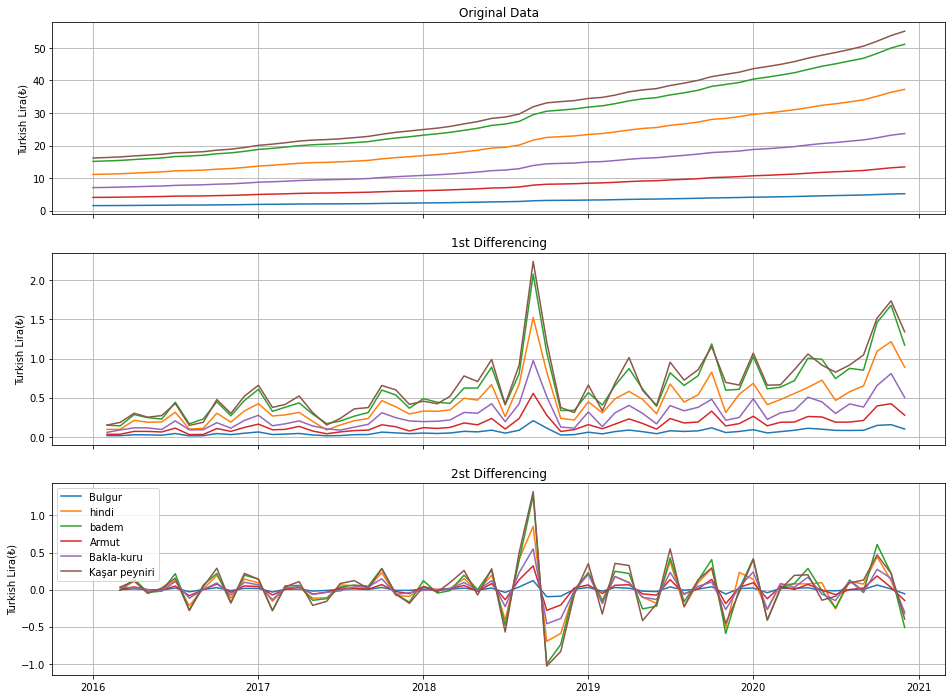

In [81]:
plt.rcParams["figure.figsize"] = (16, 12)

use_products = ['Bulgur', 'hindi', 'badem', 'Armut', 'Bakla-kuru', 'Kaşar peyniri']
use_dates = pd.date_range('2016-01-01', '2020-12-01', freq='MS')

fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].set_title('Original Data')
axes[1].set_title('1st Differencing')
axes[2].set_title('2st Differencing')

for ax in axes:
  ax.set_ylabel('Turkish Lira(₺)')
  ax.grid()

for product in use_products:
  vals = df_train.loc[use_dates, pd.IndexSlice[:, product]].mean(axis=1)
  axes[0].plot(vals)
  axes[1].plot(vals.diff())
  axes[2].plot(vals.diff().diff())

plt.legend(use_products)
plt.show()

### Average Price Based on Categories

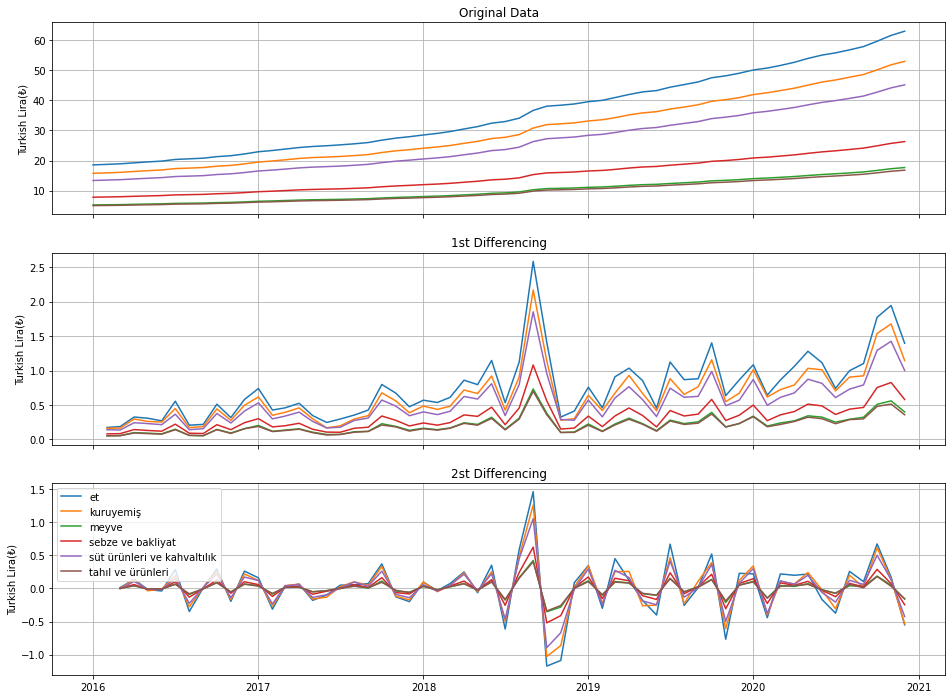

In [82]:
plt.rcParams["figure.figsize"] = (16, 12)

use_categories = ['et', 'kuruyemiş', 'meyve', 'sebze ve bakliyat', 'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri']
use_dates = pd.date_range('2016-01-01', '2020-12-01', freq='MS')

fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].set_title('Original Data')
axes[1].set_title('1st Differencing')
axes[2].set_title('2st Differencing')

for ax in axes:
  ax.set_ylabel('Turkish Lira(₺)')
  ax.grid()

for category in use_categories:
  vals = df_train.loc[use_dates, pd.IndexSlice[category]].mean(axis=1)
  axes[0].plot(vals)
  axes[1].plot(vals.diff())
  axes[2].plot(vals.diff().diff())

plt.legend(use_categories)
plt.show()

### Product Price Based on Countries

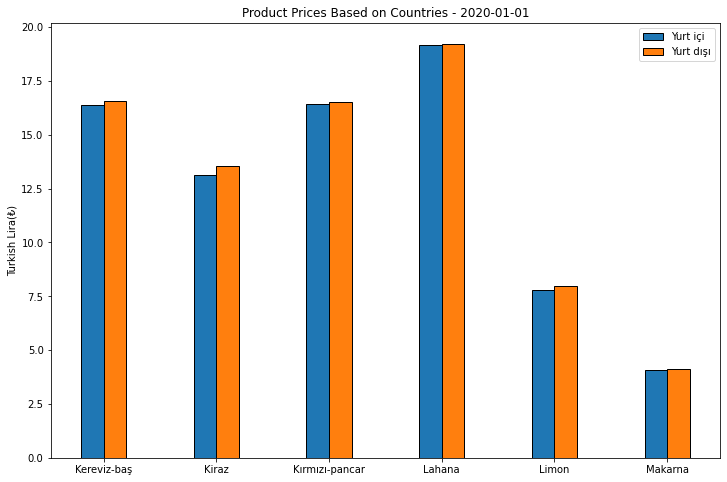

In [83]:
plt.rcParams["figure.figsize"] = (12, 8)
barWidth = 0.20

groupped_prices = df_train.groupby(['product', 'country'], axis=1).mean()

use_products = ['Kereviz-baş', 'Kiraz', 'Kırmızı-pancar', 'Lahana', 'Limon', 'Makarna']
use_countries = ['Yurt içi', 'Yurt dışı']
use_date = '2020-01-01'

for i, country in enumerate(use_countries):  
  vals = groupped_prices.loc[use_date, pd.IndexSlice[use_products, country]]
  x_ticks = [x + 0.1 + i * barWidth for x in range(len(vals))]
  plt.bar(x_ticks, vals, width=barWidth, label=product, edgecolor='black')

plt.title(f'Product Prices Based on Countries - {use_date}')
plt.ylabel('Turkish Lira(₺)')
plt.xticks([r + barWidth for r in range(len(use_products))], use_products)
 
plt.legend(use_countries)
plt.show()

### Product Price Based on Cities

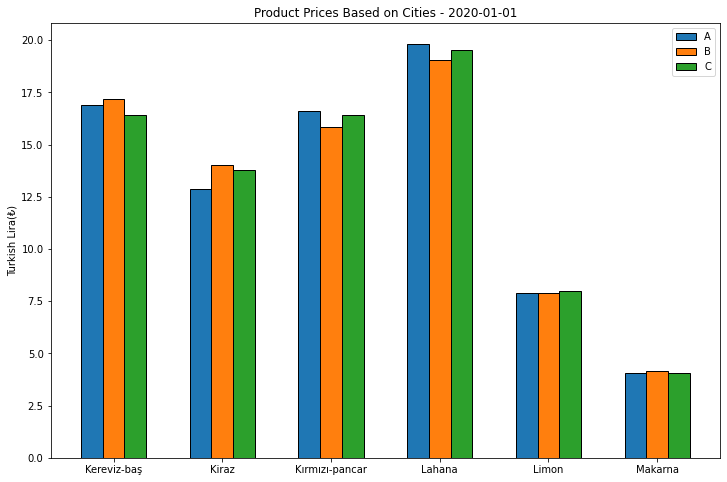

In [84]:
plt.rcParams["figure.figsize"] = (12, 8)
barWidth = 0.20

groupped_prices = df_train.groupby(['product', 'city'], axis=1).mean()

use_products = ['Kereviz-baş', 'Kiraz', 'Kırmızı-pancar', 'Lahana', 'Limon', 'Makarna']
use_cities = ['A', 'B', 'C']
use_date = '2020-01-01'

for i, city in enumerate(use_cities):  
  vals = groupped_prices.loc[use_date, pd.IndexSlice[use_products, city]]
  x_ticks = [x + i * barWidth for x in range(len(vals))]
  plt.bar(x_ticks, vals, width=barWidth, label=product, edgecolor='black')

plt.title(f'Product Prices Based on Cities - {use_date}')
plt.ylabel('Turkish Lira(₺)')
plt.xticks([r + barWidth for r in range(len(use_products))], use_products)
 
plt.legend(use_cities)
plt.show()

### Product Price Based on Markets

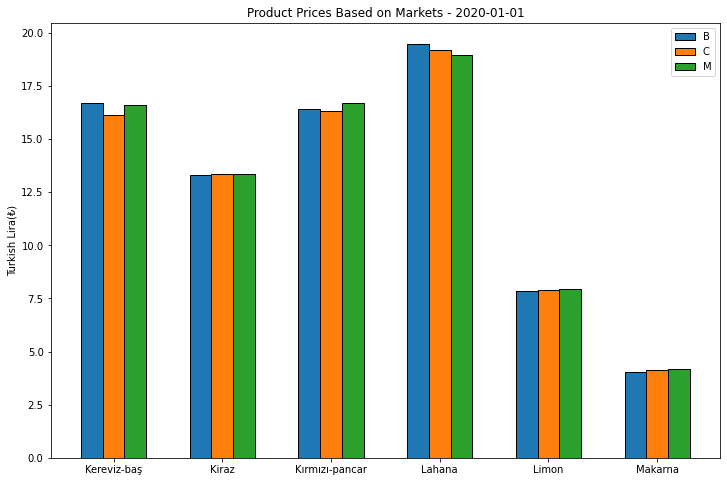

In [85]:
plt.rcParams["figure.figsize"] = (12, 8)
barWidth = 0.20

groupped_prices = df_train.groupby(['product', 'market'], axis=1).mean()

use_products = ['Kereviz-baş', 'Kiraz', 'Kırmızı-pancar', 'Lahana', 'Limon', 'Makarna']
use_markets = ['B', 'C', 'M']
use_date = '2020-01-01'

for i, market in enumerate(use_markets):  
  vals = groupped_prices.loc[use_date, pd.IndexSlice[use_products, market]]
  x_ticks = [x + i * barWidth for x in range(len(vals))]
  plt.bar(x_ticks, vals, width=barWidth, label=product, edgecolor='black')

plt.title(f'Product Prices Based on Markets - {use_date}')
plt.ylabel('Turkish Lira(₺)')
plt.xticks([r + barWidth for r in range(len(use_products))], use_products)
 
plt.legend(use_markets)
plt.show()

### Statistical Tests

#### Seasonal Decomposition

Info

* The Seasonal Decomposition procedure decomposes a series into a seasonal component, a combined trend and an "error" component.

Conclusion

* No real-world seasonal price fluctuations were observed in products.
* No significant seasonal price fluctuation was observed in products.

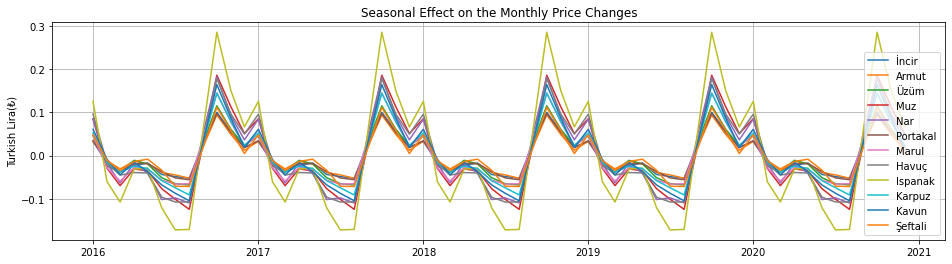

In [86]:
plt.rcParams["figure.figsize"] = (16, 4)

use_products = ['İncir', 'Armut', 'Üzüm',     # september products 
                'Muz', 'Nar', 'Portakal',     # winter products
                'Marul', 'Havuç', 'Ispanak',  # spring products
                'Karpuz', 'Kavun', 'Şeftali'] # summer products

fig, ax = plt.subplots(1, 1, sharex=True)

ax.set_title('Seasonal Effect on the Monthly Price Changes')
ax.set_ylabel('Turkish Lira(₺)')
ax.grid()

for product in use_products:
  vals = df_train.loc[:, pd.IndexSlice[:, product]].mean(axis=1)
  results = seasonal_decompose(vals, model='additive', period=12)
  ax.plot(results.seasonal)

plt.legend(use_products)
plt.show()

#### KPSS test

Info

* Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests are used for testing a null hypothesis that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

Conclusion

* The data has non stationary trend.

In [87]:
use_series = random.choice(df_train.columns)
vals = df_train.loc[:, use_series]

statistic, p_value, n_lags, critical_values = kpss(vals, nlags=1)

print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')

for key, value in critical_values.items():
  print(f'\t{key} : {value}')

print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 3.079295982835893
p-value: 0.01
num lags: 1
Critial Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The series is not stationary


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2012: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


#### Dickey Fuller Test

Info

* Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model.

Conclusion

* The data has a quadratic trend.

In [88]:
use_series = random.choice(df_train.columns)
vals = df_train.loc[:, use_series]

print(f'Adfuller Test For "{use_series[1]}"\n\n')
for order in [0, 1, 2]:
    statistic, p_value, _, _, critical_values, _ = adfuller(vals)
    
    print(f'Order: {order}')
    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')

    for key, value in critical_values.items():
        print(f'\t{key}: {value:.3f}')
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary\n')
        
    vals = vals.diff().dropna()

Adfuller Test For "Barbunya-kuru"


Order: 0
ADF Statistic: 2.5946149452172005
p-value: 0.999074139704054
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
Result: The series is not stationary

Order: 1
ADF Statistic: -2.359100943548943
p-value: 0.15361404324351458
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Result: The series is not stationary

Order: 2
ADF Statistic: -7.988334923174345
p-value: 2.5135393224947177e-12
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Result: The series is stationary



#### Granger Casuality Tests

Info

* The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.

Conclusion

* USD exchange is useful for predicting price productions.

In [89]:
use_series = random.choice(df_train.columns)
use_currency = 'USD'
use_dates = pd.date_range('2016-01-01', '2020-12-01', freq='MS')

vals = df_train.loc[use_dates, use_series]
vals = vals.diff().diff().dropna()

curr = df_currency.loc[use_dates, use_currency]
curr = curr.diff().diff().dropna()

results = grangercausalitytests(pd.concat([vals, curr], axis=1), maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9693  , p=0.0179  , df_denom=54, df_num=1
ssr based chi2 test:   chi2=6.3009  , p=0.0121  , df=1
likelihood ratio test: chi2=5.9763  , p=0.0145  , df=1
parameter F test:         F=5.9693  , p=0.0179  , df_denom=54, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5620  , p=0.0870  , df_denom=51, df_num=2
ssr based chi2 test:   chi2=5.6263  , p=0.0600  , df=2
likelihood ratio test: chi2=5.3612  , p=0.0685  , df=2
parameter F test:         F=2.5620  , p=0.0870  , df_denom=51, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0269  , p=0.0384  , df_denom=48, df_num=3
ssr based chi2 test:   chi2=10.4049 , p=0.0154  , df=3
likelihood ratio test: chi2=9.5295  , p=0.0230  , df=3
parameter F test:         F=3.0269  , p=0.0384  , df_denom=48, df_num=3


#### Auto Correlation and Partial Auto Correlation

Info

* Auto Correlation is the similarity between observations as a function of the time lag between them. 

* Partial Auto Correlation gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags.

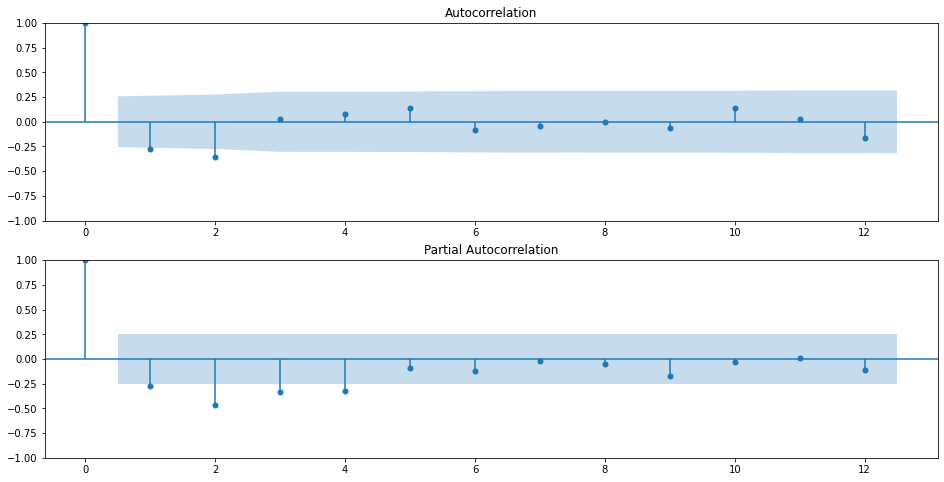

In [90]:
use_series = random.choice(df_train.columns)
vals = df_train.loc[:, use_series].diff().diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

_ = plot_acf(vals, ax=axes[0], lags=12)
_ = plot_pacf(vals, ax=axes[1], lags=12, method='ywm')

### Comparing Exhange Rate and Product Prices

In [91]:
df_currency.head()

,EUR,USD,CNY,GBP,JPY,RUB
Tarih,,,,,,
2016-01-01,3.266920,3.006950,0.455104,4.330805,2.540060,0.038822
2016-02-01,3.262800,2.940662,0.446417,4.207195,2.548419,0.037928
2016-03-01,3.206348,2.891739,0.441632,4.097348,2.553361,0.040817
2016-04-01,3.213405,2.834738,0.435186,4.045233,2.574938,0.042260
2016-05-01,3.314733,2.926595,0.446050,4.244290,2.686748,0.044292


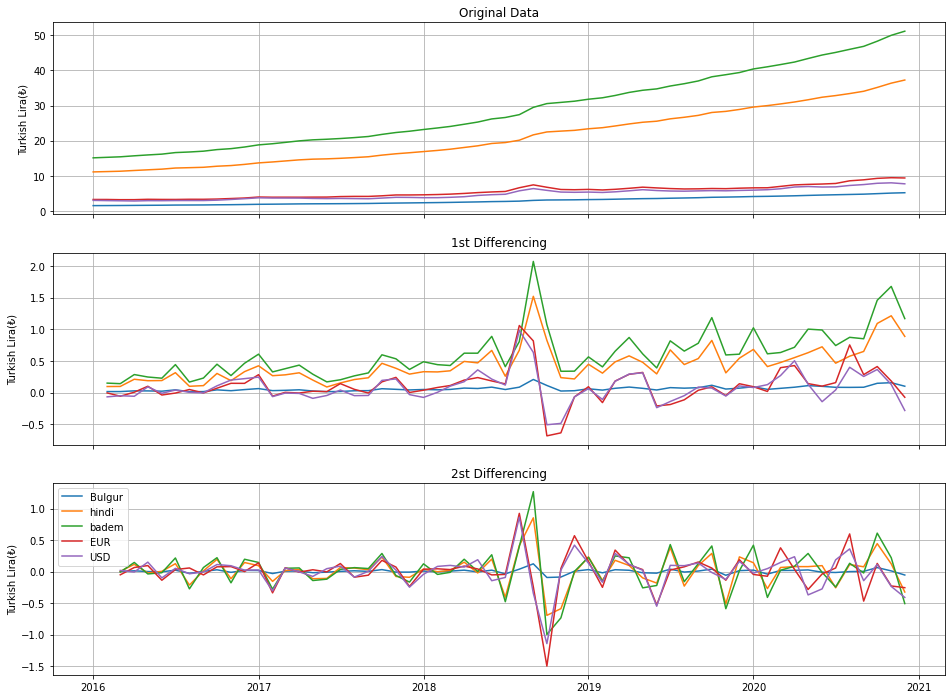

In [92]:
plt.rcParams["figure.figsize"] = (16, 12)

use_currency = ['EUR', 'USD']
use_products = ['Bulgur', 'hindi', 'badem']
use_dates    = pd.date_range('2016-01-01', '2020-12-01', freq='MS')

fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].set_title('Original Data')
axes[1].set_title('1st Differencing')
axes[2].set_title('2st Differencing')

for ax in axes:
  ax.set_ylabel('Turkish Lira(₺)')
  ax.grid()

for product in use_products:
  vals = df_train.loc[use_dates, pd.IndexSlice[:, product]].mean(axis=1)
  axes[0].plot(vals)
  axes[1].plot(vals.diff())
  axes[2].plot(vals.diff().diff())

for currency in use_currency:
  vals = df_currency.loc[use_dates, currency]
  axes[0].plot(vals)
  axes[1].plot(vals.diff())
  axes[2].plot(vals.diff().diff())

plt.legend(use_products + use_currency)
plt.show()

### Correlation Matrices between Product Prices and Exchange Rates

#### Correlation Matrix Based on Categories

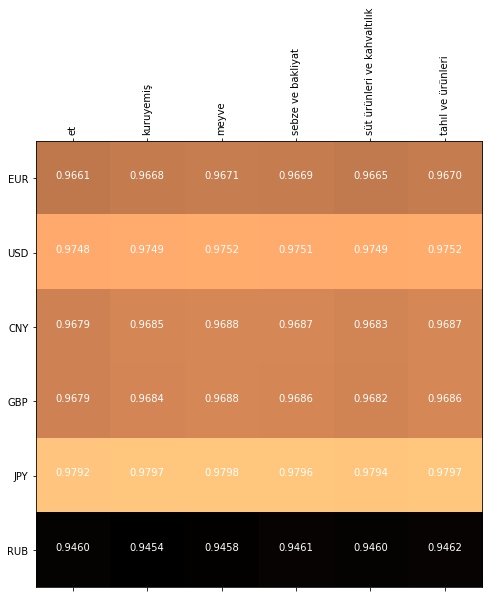

In [93]:
use_currency = ['EUR', 'USD', 'CNY', 'GBP', 'JPY', 'RUB']
use_category = ['et', 'kuruyemiş', 'meyve', 'sebze ve bakliyat', 'süt ürünleri ve kahvaltılık', 'tahıl ve ürünleri']

corr_matrix = np.zeros((len(use_currency), len(use_categories)))

for i, j in itertools.product(range(len(use_currency)), range(len(use_categories))):
  currency = df_currency.loc[:, use_currency[i]]
  product = df_train.loc[:, pd.IndexSlice[use_categories[j]]].mean(axis=1)
  corr_matrix[i, j] = product.corr(currency)

plt.figure(figsize = (8, 8))
plt.matshow(corr_matrix, fignum=1, cmap=plt.cm.copper)

plt.xticks(range(len(use_categories)), use_categories, rotation='vertical')
plt.yticks(range(len(use_currency)), use_currency, rotation='horizontal')

for i, j in itertools.product(range(len(use_currency)), range(len(use_categories))):
  plt.text(j, i, f'{corr_matrix[i, j]:0.4f}', color='white', horizontalalignment='center')

plt.show()

#### Correlation Matrix Based on Products

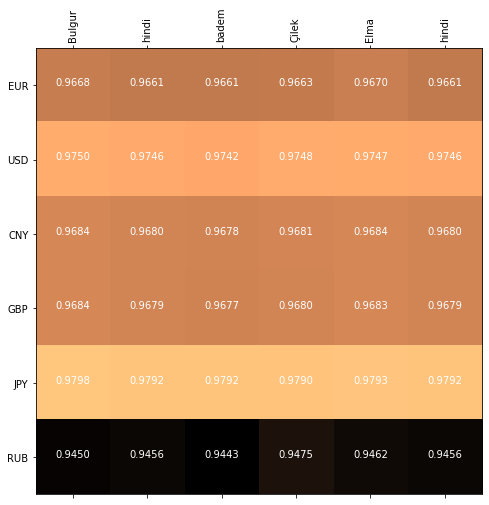

In [94]:
use_currency = ['EUR', 'USD', 'CNY', 'GBP', 'JPY', 'RUB']
use_products = ['Bulgur', 'hindi', 'badem', 'Çilek', 'Elma', 'hindi']

corr_matrix = np.zeros((len(use_currency), len(use_products)))

for i, j in itertools.product(range(len(use_currency)), range(len(use_products))):
  currency = df_currency.loc[:, use_currency[i]]
  product = df_train.loc[:, pd.IndexSlice[:, use_products[j]]].mean(axis=1)
  corr_matrix[i, j] = product.corr(currency)

plt.figure(figsize = (8, 8))
plt.matshow(corr_matrix, fignum=1, cmap=plt.cm.copper)

plt.xticks(range(len(use_products)), use_products, rotation='vertical')
plt.yticks(range(len(use_currency)), use_currency, rotation='horizontal')

for i, j in itertools.product(range(len(use_currency)), range(len(use_products))):
  plt.text(j, i, f'{corr_matrix[i, j]:0.4f}', color='white', horizontalalignment='center')

plt.show()

#### Correlation Matrix Based on Countries

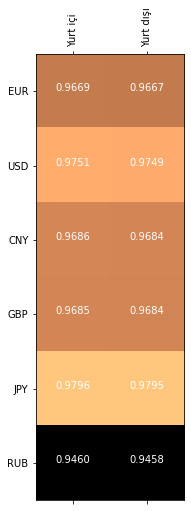

In [95]:
use_currency = ['EUR', 'USD', 'CNY', 'GBP', 'JPY', 'RUB']
use_countries = ['Yurt içi', 'Yurt dışı']

corr_matrix = np.zeros((len(use_currency), len(use_countries)))

for i, j in itertools.product(range(len(use_currency)), range(len(use_countries))):
  currency = df_currency.loc[:, use_currency[i]]
  product = df_train.loc[:, pd.IndexSlice[:, :, use_countries[j]]].mean(axis=1)
  corr_matrix[i, j] = product.corr(currency)

plt.figure(figsize = (8, 8))
plt.matshow(corr_matrix, fignum=1, cmap=plt.cm.copper)

plt.xticks(range(len(use_countries)), use_countries, rotation='vertical')
plt.yticks(range(len(use_currency)), use_currency, rotation='horizontal')

for i, j in itertools.product(range(len(use_currency)), range(len(use_countries))):
  plt.text(j, i, f'{corr_matrix[i, j]:0.4f}', color='white', horizontalalignment='center')

plt.show()

## METHOD-1 (ARIMA)

* p: number of autoregressive terms (AR order)
* d: number of nonseasonal differences (differencing order)
* q: number of moving-average terms (MA order)

In [96]:
use_series = random.choice(df_train.columns)
use_train_dates = pd.date_range('2016-01-01', '2019-12-01', freq='MS')
use_valid_dates = pd.date_range('2020-01-01', '2020-12-01', freq='MS')
order = (3, 2, 0)

train_x = df_train.loc[use_train_dates, use_series]
test_x = df_train.loc[use_valid_dates, use_series]

In [97]:
model = ARIMA(train_x, order=order, freq='MS')
result = model.fit()
print(result.summary())

                                                    SARIMAX Results                                                    
Dep. Variable:     ('sebze ve bakliyat', 'Fasulye-kuru', 'Yurt içi', 'H', 'C')   No. Observations:                   48
Model:                                                          ARIMA(3, 2, 0)   Log Likelihood                  -5.360
Date:                                                         Thu, 07 Apr 2022   AIC                             18.720
Time:                                                                 07:04:58   BIC                             26.035
Sample:                                                             01-01-2016   HQIC                            21.460
                                                                  - 12-01-2019                                         
Covariance Type:                                                           opg                                         
                 coef    std err        

In [98]:
forecast = result.get_forecast(steps=12)
fc = forecast.predicted_mean

conf = forecast.conf_int(alpha=0.05)
lower = conf.iloc[:, 0]
upper = conf.iloc[:, 1]

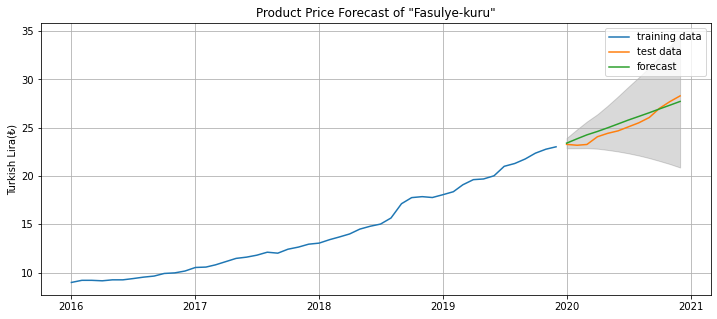

MSE: 0.3538880108488481


In [99]:
plt.figure(figsize=(12,5))
plt.title(f'Product Price Forecast of "{use_series[1]}"')

plt.plot(train_x, label='training data')
plt.plot(test_x, label='test data')
plt.plot(fc, label='forecast')

plt.fill_between(lower.index, lower.values, upper.values, color='k', alpha=.15)

plt.ylabel('Turkish Lira(₺)')
plt.legend()
plt.grid()
plt.show()

print(f'MSE: {((test_x - fc) * (test_x - fc)).mean()}')

## METHOD-2 (VAR)

* p: number of var terms (VAR order)

In [132]:
use_series = random.choice(df_train.columns)
use_currency = 'USD'
use_train_dates = pd.date_range('2016-01-01', '2019-12-01', freq='MS')
use_valid_dates = pd.date_range('2020-01-01', '2020-12-01', freq='MS')

train_X1 = df_train.loc[use_train_dates, use_series]
train_X2 = df_currency.loc[use_train_dates, use_currency]

train_x = np.column_stack([
    train_X1.diff().diff().dropna(), 
    train_X2.diff().diff().dropna()])

test_X1 = df_train.loc[use_valid_dates, use_series]
test_X2 = df_currency.loc[use_valid_dates, use_currency]

In [133]:
model = VAR(train_x)
result = model.fit(4)
print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Apr, 2022
Time:                     07:22:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.78439
Nobs:                     42.0000    HQIC:                  -6.25614
Log likelihood:           35.9204    FPE:                 0.00148015
AIC:                     -6.52911    Det(Omega_mle):      0.00100384
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.008257         0.027038            0.305           0.760
L1.y1        -0.936851         0.174927           -5.356           0.000
L1.y2         0.460515         0.156405            2.944           0.003
L2.y1        -0.370145

In [134]:
fc, lower, upper = result.forecast_interval(train_x[-4:], steps=12)

fc_1 = (train_X1.iloc[-1] - train_X1.iloc[-2]) + fc[:, 0].cumsum() # to 1st diff
fc_1 = train_X1.iloc[-1] + fc_1.cumsum() # to 0st diff

fc_2 = (train_X2.iloc[-1] - train_X2.iloc[-2]) + fc[:, 1].cumsum() # to 1st diff
fc_2 = train_X2.iloc[-1] + fc_2.cumsum() # to 0st diff

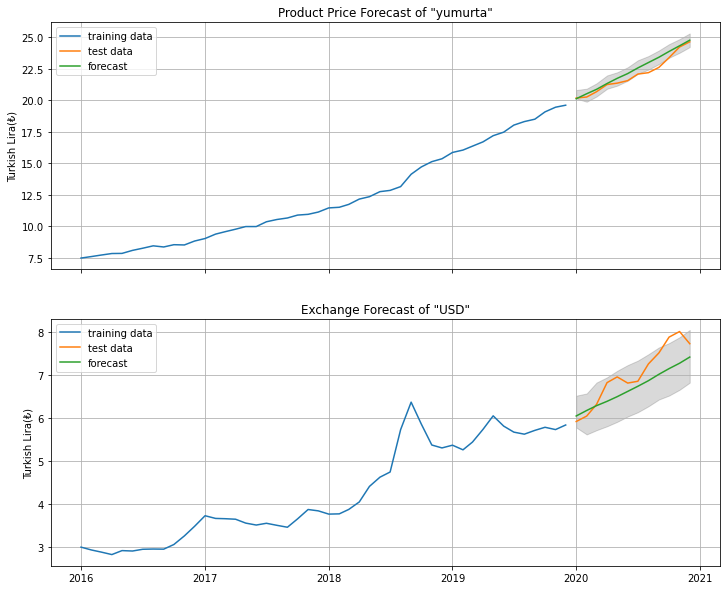

MSE(product): 0.19785359619330423
MSE(currency): 0.1706209665549937


In [135]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True)

axes[0].set_title(f'Product Price Forecast of "{use_series[1]}"')
axes[0].plot(train_X1, label='training data')
axes[0].plot(test_X1, label='test data')
axes[0].plot(use_valid_dates, fc_1, label='forecast')
axes[0].fill_between(use_valid_dates, fc_1 + lower[:, 0], fc_1 + upper[:, 0], color='k', alpha=.15)

axes[1].set_title(f'Exchange Forecast of "{use_currency}"')
axes[1].plot(train_X2, label='training data')
axes[1].plot(test_X2, label='test data')
axes[1].plot(use_valid_dates, fc_2, label='forecast')
axes[1].fill_between(use_valid_dates, fc_2 + lower[:, 1], fc_2 + upper[:, 1], color='k', alpha=.15)

for ax in axes:
    ax.set_ylabel('Turkish Lira(₺)')
    ax.legend()
    ax.grid()

plt.show()

print(f'MSE(product): {((test_X1 - fc_1) * (test_X1 - fc_1)).mean()}')
print(f'MSE(currency): {((test_X2 - fc_2) * (test_X2 - fc_2)).mean()}')

## METHOD-3 (LSTM)

In [104]:
use_series = random.choice(df_train.columns)
use_currency = 'USD'
use_train_dates = pd.date_range('2016-01-01', '2019-12-01', freq='MS')
use_valid_dates = pd.date_range('2020-01-01', '2020-12-01', freq='MS')
nsteps = 6

model = Sequential([
    LSTM(units=128, input_shape=(nsteps, 2), return_sequences=True),
    LSTM(units=128),
    Dense(units=64),
    Dense(units=2)
])

scaler = MinMaxScaler(feature_range=(0, 1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [105]:
train_X1 = df_train.loc[use_train_dates, use_series]
train_X2 = df_currency.loc[use_train_dates, use_currency]

test_X1 = df_train.loc[use_valid_dates, use_series]
test_X2 = df_currency.loc[use_valid_dates, use_currency]

train_data = np.column_stack([train_X1, train_X2])
scaler.fit(train_data)
train_data = scaler.transform(train_data)

train_x = np.array([train_data[i - nsteps:i] for i in range(nsteps, len(train_data))])
train_y = np.array([train_data[i] for i in range(nsteps, len(train_data))])

In [106]:
model.fit(x=train_x, y=train_y, batch_size=4, epochs=10)

Epoch 1/10
11/11 [==============================] - 5s 13ms/step - loss: 0.1285
Epoch 2/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0270
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0126
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0112
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0086
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0080
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0077
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0082
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0099
Epoch 10/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0078


In [107]:
test_x = train_x[-1].reshape(1, nsteps, 2)
fc = np.zeros((12, 2))

for i in range(12):
  pred = model.predict(test_x)
  fc[i] = pred[0]
  test_x = np.hstack([test_x[:, -(nsteps - 1):], pred.reshape(1, 1, 2)])

fc = scaler.inverse_transform(fc)

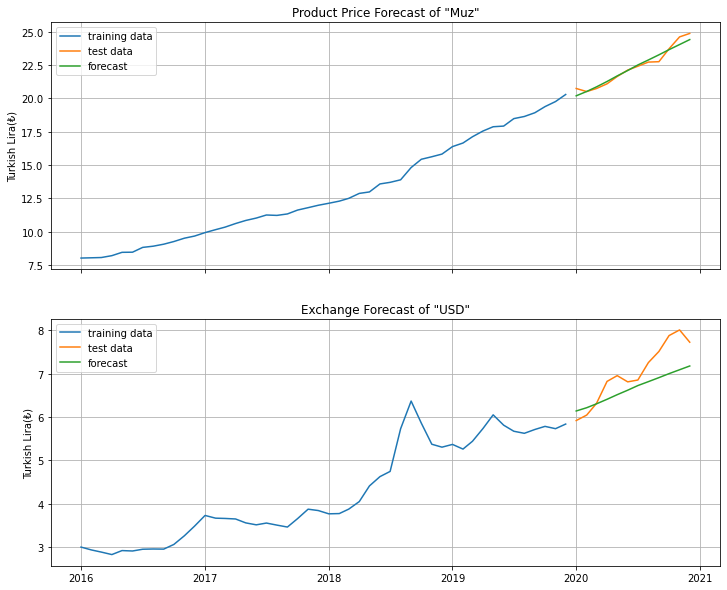

MSE(product): 0.09982153332268452
MSE(currency): 0.24600005692469515


In [108]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True)

axes[0].set_title(f'Product Price Forecast of "{use_series[1]}"')
axes[0].plot(train_X1, label='training data')
axes[0].plot(test_X1, label='test data')
axes[0].plot(use_valid_dates, fc[:, 0], label='forecast')

axes[1].set_title(f'Exchange Forecast of "{use_currency}"')
axes[1].plot(train_X2, label='training data')
axes[1].plot(test_X2, label='test data')
axes[1].plot(use_valid_dates, fc[:, 1], label='forecast')

for ax in axes:
    ax.set_ylabel('Turkish Lira(₺)')
    ax.legend()
    ax.grid()

plt.show()

print(f'MSE(product): {((test_X1 - fc[:, 0]) * (test_X1 - fc[:, 0])).mean()}')
print(f'MSE(currency): {((test_X2 - fc[:, 1]) * (test_X2 - fc[:, 1])).mean()}')

## METHOD-4 (Extrapolation with Polynomial)

In [121]:
use_product = random.choice(df_train.columns)
poly_degree = 2

train_y = df_train[use_product].iloc[:48]
test_y = df_train[use_product].iloc[48:]

y = train_y.values
y = y[:, np.newaxis]
x = np.linspace(0, len(y), len(y), endpoint=False)[:, np.newaxis]

In [122]:
model = make_pipeline(PolynomialFeatures(poly_degree), Ridge(alpha=1e-3))
model.fit(x, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=0.001))])

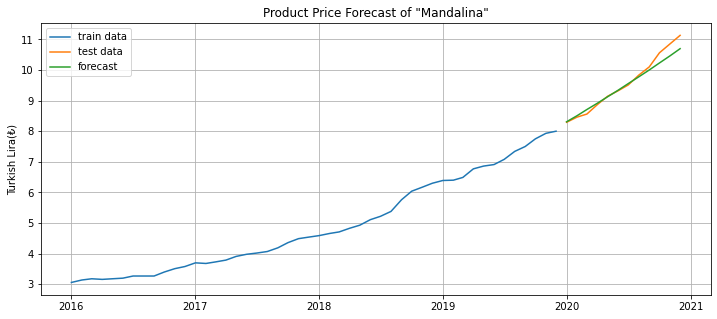

MSE: 0.04115848133434402


In [123]:
fc_y = pd.Series(data=[model.predict([[x]])[0, 0] for x in range(48, 60)], index=test_y.index)

plt.figure(figsize=(12,5))

plt.title(f'Product Price Forecast of "{use_product[1]}"')
plt.ylabel('Turkish Lira(₺)')

plt.plot(train_y, label='train data')
plt.plot(test_y, label='test data')
plt.plot(fc_y, label='forecast')

plt.legend()
plt.grid()
plt.show()

print(f'MSE: {((fc_y - test_y) * (fc_y - test_y)).mean()}')

## Score Boosting - Prediction of Bias

The real data has upper trend that makes loss value higher. We should add some sort of bias to the prediction series.

In [115]:
# constant bias

W0 = np.array([1.00 for _ in range(12)])
W1 = np.array([1.01 for _ in range(12)])
W2 = np.array([1.02 for _ in range(12)])
W3 = np.array([1.04 for _ in range(12)])
W4 = np.array([1.08 for _ in range(12)])
W5 = np.array([1.16 for _ in range(12)])

# linear weighted bias

W6 = np.array([1.0 + 0.16 * (i / 12) for i in range(1, 13)])
W7 = np.array([1.0 + 0.20 * (i / 12) for i in range(1, 13)])
W8 = np.array([1.0 + 0.26 * (i / 12) for i in range(1, 13)])

# USD exchange weighted bias

vals = df_currency.loc['2021-01-01': '2021-12-01', 'USD'].values
vals = (vals - vals.min()) / (vals.max() - vals.min())

W9 = np.array([1.0 + 0.16 * i for i in vals])

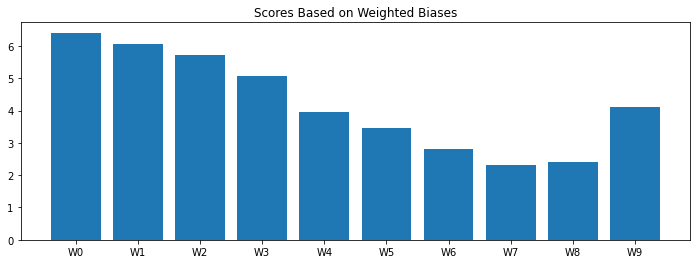

In [116]:
fig = plt.subplots(figsize=(12, 4))

labels = ['W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9']
scores = [6.41, 6.06, 5.72, 5.07, 3.96, 3.47, 2.80, 2.30, 2.41, 4.10]

plt.title('Scores Based on Weighted Biases')
plt.bar(labels, scores)
plt.show()

## Forecasting

In [117]:
df_test.head()

,id,ürün,ürün besin değeri,ürün kategorisi,ürün üretim yeri,market,şehir
tarih,,,,,,,
2021-01-01,0,kıyma,120,et,Yurt içi,M,A
2021-01-01,1,tavuk,103,et,Yurt içi,M,A
2021-01-01,2,hindi,160,et,Yurt içi,M,A
2021-01-01,3,Bakla-kuru,354,sebze ve bakliyat,Yurt içi,M,A
2021-01-01,4,Bakla-taze,72,sebze ve bakliyat,Yurt içi,M,A


In [118]:
df_forecast = pd.DataFrame(0, columns=df_train.columns, index=df_test.index.unique())
order = (3, 2, 0)
weight_coefs = W7
forecast_data = {}

for col in df_forecast.columns:
  model = ARIMA(df_train[col].values, order=order)
  fitted = model.fit()
  fc = weight_coefs * fitted.forecast(len(df_forecast))
  df_forecast.loc[:, col] = pd.Series(fc, index=df_forecast.index)

for idx, row in df_test.iterrows():
  fc_val = df_forecast.loc[idx, (row['ürün kategorisi'], row['ürün'], row['ürün üretim yeri'], row['şehir'], row['market'])]
  forecast_data[row['id']] = fc_val

df_result = pd.DataFrame(data    = [[idx, val] for idx, val in forecast_data.items()], 
                         columns = ['id', 'ürün fiyatı'])

In [119]:
df_result.head()

,id,ürün fiyatı
0,0,120.594222
1,1,38.935138
2,2,39.409929
3,3,23.712830
4,4,42.535492


In [120]:
df_result.to_csv('/kaggle/working/submission.csv', index=False)